In [73]:
"""
Land cover assessments for MODIS and VIIRS AFDs for the Southern Rockies

Data sources:
    - United States Forest Service (USFS) TreeMap c.a. 2016
    - Sentinel-based aspen cover (Cook et al.)
    - LANDFIRE Existing Vegetation Type (EVT) proportional cover
    - LANDFIRE Canopy Bulk Density (CBD) mean
    - LANDIFRE Canopy Base Height (CBH) mean
    - LANDFIRE Canopy Cover (CC) percentage
    
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [55]:
# Load the combined MODIS and VIIRS AFDs (buffered)
fp = os.path.join(projdir,f'data/spatial/mod/AFD/combined-afd_aspen-fires_2018_to_2023_buffer.gpkg')
afds = gpd.read_file(fp)
afds.columns

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'VID', 'NIFC_ID', 'NIFC_NAME',
       'START_YEAR', 'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'na_l3name',
       'ACQ_MONTH', 'ACQ_YEAR', 'ACQ_DATETIME', 'afdID', 'geometry'],
      dtype='object')

In [56]:
# Subset to the Southern Rockies (for now)
afds_srm = afds[afds['na_l3name'] == 'Southern Rockies'] # subset to SRM
print(f"There are [{len(afds_srm['NIFC_ID'].unique())}/{len(afds['NIFC_ID'].unique())}] fire events in the Southern Rockies (2018-2023).")

There are [61/173] fire events in the Southern Rockies (2018-2023).


In [6]:
# Check the number of observations per fire
afd_counts = afds_srm.groupby(['NIFC_ID','INSTRUMENT']).size().reset_index(name='counts')
print(afd_counts.head(10))
print(f"Minimum obs./fire: {afd_counts['counts'].min()}; \nMaximum obs./fire: {afd_counts['counts'].max()}")

  NIFC_ID INSTRUMENT  counts
0   13356      MODIS    3397
1   13356      VIIRS   12563
2   13363      MODIS      28
3   13363      VIIRS      88
4   13378      VIIRS       2
5   13494      MODIS       3
6   13494      VIIRS      16
7   13652      MODIS     928
8   13652      VIIRS    3956
9      14      MODIS     557
Minimum obs./fire: 1; 
Maximum obs./fire: 12563


In [7]:
len(afd_counts[afd_counts['counts'] > 10]['NIFC_ID'].unique())

49

In [8]:
# Tidy columns for simplicity.
afds_ = afds_srm[['afdID','geometry']]
afds_.head()

,afdID,geometry
0,MODIS7298,"POLYGON ((-1334259.255 1940525.281, -1334259.2..."
1,MODIS7301,"POLYGON ((-1335247.149 1940508.597, -1335247.1..."
2,MODIS7989,"POLYGON ((-1149036.475 2035501.025, -1149036.4..."
3,MODIS7990,"POLYGON ((-1148030.494 2035535.701, -1148030.4..."
4,MODIS7991,"POLYGON ((-1148997.363 2034487.930, -1148997.3..."


In [9]:
bounds = afds_.total_bounds # for cropping

In [10]:
# Add a small buffer to the AFD observations (edge effects)
buffer_dist = 30  # meters
afds_b = afds_.copy() # make a copy of the original data
afds_b['geometry'] = afds_b['geometry'].buffer(buffer_dist)
print(f"Buffered AFD observations by {buffer_dist} meters.")

Buffered AFD observations by 30 meters.


In [76]:
# out_fp = os.path.join(projdir,'data/earth-engine/imports/afd_aspen-fires_2018_to_2023_bounds30.shp')
# afds_b.to_file(out_fp)

## USFS TreeMap c.a. 2016

In [67]:
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_FORTYPCD/TreeMap2016_FORTYPCD.tif')
tmap_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = tmap_da.shape, tmap_da.spatial_ref.GeoTransform, tmap_da.rio.crs, tmap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tmap_da[0].dtype}")
gc.collect()

Shape: (97383, 154221); 
GeoTransform: -2362845.0 30.0 0.0 3180555.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


9742

In [68]:
# Crop to AFD total bounds
tmap_da_crop = tmap_da.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del tmap_da
gc.collect()

85139

In [69]:
t0 = time.time()

# Get the proportional landcover
afds_tmap = compute_band_stats(
    geoms=afds_, 
    image_da=tmap_da_crop, 
    id_col='afdID',
    attr='treemap'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 1.81 minutes.

~~~~~~~~~~



In [70]:
afds_tmap.head()

,afdID,treemap,count,total_pixels,pct_cover
0,MODIS7298,182,2.0,994.0,0.201207
1,MODIS7298,185,75.0,994.0,7.545272
2,MODIS7298,201,88.0,994.0,8.853119
3,MODIS7298,221,208.0,994.0,20.925553
4,MODIS7298,261,87.0,994.0,8.752515


## LANDFIRE Existing Vegetation Type (EVT) c.a. 2016

In [11]:
fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
evt_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = evt_da.shape, evt_da.spatial_ref.GeoTransform, evt_da.rio.crs, evt_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt_da[0].dtype}")
gc.collect()

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


556

In [12]:
evt_da_crop = evt_da.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del evt_da
gc.collect()

66

In [44]:
t0 = time.time()

# Get the proportional landcover
afds_evt = compute_band_stats(
    geoms=afds_b, 
    image_da=evt_da_crop, 
    id_col='afdID'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 1.88 minutes.

~~~~~~~~~~



In [45]:
afds_evt.head()

,afdID,evt,count,total_pixels,pct_cover
0,MODIS7298,7011,103.0,1190.0,8.655462
1,MODIS7298,7012,306.0,1190.0,25.714286
2,MODIS7298,7016,306.0,1190.0,25.714286
3,MODIS7298,7051,82.0,1190.0,6.890756
4,MODIS7298,7052,171.0,1190.0,14.369748


In [46]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [47]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS','EVT_SBCLS']]
afds_evt_ = afds_evt.merge(lookup, left_on='evt', right_on='VALUE', how='left')
afds_evt_.drop('VALUE', axis=1, inplace=True)
afds_evt_.head()

,afdID,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS,EVT_SBCLS
0,MODIS7298,7011,103.0,1190.0,8.655462,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy,Deciduous open tree canopy
1,MODIS7298,7012,306.0,1190.0,25.714286,Rocky Mountain Bigtooth Maple Ravine Woodland,Hardwood,Bigtooth Maple Woodland,Open tree canopy,Deciduous open tree canopy
2,MODIS7298,7016,306.0,1190.0,25.714286,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,Open tree canopy,Evergreen open tree canopy
3,MODIS7298,7051,82.0,1190.0,6.890756,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy,Evergreen closed tree canopy
4,MODIS7298,7052,171.0,1190.0,14.369748,Southern Rocky Mountain Mesic Montane Mixed Co...,Conifer,Douglas-fir-Grand Fir-White Fir Forest and Woo...,Closed tree canopy,Evergreen closed tree canopy


In [51]:
evt_counts = afds_evt_.groupby(['evt','EVT_GP_N']).size().reset_index(name='counts')
evt_counts.sort_values('counts', ascending=False, inplace=True)
evt_counts.head(10)

,evt,EVT_GP_N,counts
2,7011,"Aspen Forest, Woodland, and Parkland",81839
25,7051,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,74776
29,7055,Spruce-Fir Forest and Woodland,74139
28,7054,"Ponderosa Pine Forest, Woodland and Savanna",57110
66,7126,Big Sagebrush Shrubland and Steppe,55411
24,7050,Lodgepole Pine Forest and Woodland,54783
26,7052,Douglas-fir-Grand Fir-White Fir Forest and Woo...,45311
57,7107,Deciduous Shrubland,43672
78,7146,Grassland,40197
77,7145,"Alpine Dwarf-Shrubland, Fell-field and Meadow",34957


In [52]:
# Export a table of the EVT values found in AFD observations
lookup_ = lookup[lookup['VALUE'].isin(afds_evt['evt'].unique())]
out_fp = os.path.join(projdir,'data/tabular/mod/EVT/afd_evt_codes-SRM.csv')
lookup_.to_csv(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/afd_evt_codes-SRM.csv


In [58]:
# Identify the dominant EVT class for each observation
dominant_evt = afds_evt_.loc[afds_evt.groupby('afdID')['pct_cover'].idxmax()]
dominant_evt.head()

,afdID,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS,EVT_SBCLS
5404,MODIS10000,7051,543.0,1190.0,45.630252,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy,Evergreen closed tree canopy
5414,MODIS10003,7051,804.0,1225.0,65.632653,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy,Evergreen closed tree canopy
5423,MODIS10004,7051,489.0,1190.0,41.092437,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy,Evergreen closed tree canopy
5431,MODIS10027,7016,534.0,1225.0,43.591837,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,Open tree canopy,Evergreen open tree canopy
5447,MODIS10028,7016,704.0,1190.0,59.159664,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,Open tree canopy,Evergreen open tree canopy


In [ ]:
# Join to the FRP

In [59]:
frp = afds_srm[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
evt = dominant_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]
frp_evt_srm = pd.merge(frp, dominant_evt, on='afdID', how='left')
frp_evt_srm.head()

,afdID,INSTRUMENT,ACQ_DATETIME,DAYNIGHT,FRP,na_l3name,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS,EVT_SBCLS
0,MODIS8479,MODIS,2018-06-01 18:15:00+00:00,D,17.3,Southern Rockies,7054,422.0,1156.0,36.505190,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",Open tree canopy,Evergreen open tree canopy
1,MODIS8480,MODIS,2018-06-01 18:15:00+00:00,D,87.1,Southern Rockies,7107,419.0,1156.0,36.245675,Rocky Mountain Gambel Oak-Mixed Montane Shrubland,Shrubland,Deciduous Shrubland,Shrubland,Mixed evergreen-deciduous shrubland
2,MODIS8481,MODIS,2018-06-01 18:15:00+00:00,D,174.5,Southern Rockies,7054,639.0,1190.0,53.697479,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",Open tree canopy,Evergreen open tree canopy
3,MODIS8482,MODIS,2018-06-01 18:15:00+00:00,D,92.2,Southern Rockies,7051,372.0,1156.0,32.179931,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy,Evergreen closed tree canopy
4,MODIS8483,MODIS,2018-06-01 18:15:00+00:00,D,235.6,Southern Rockies,7054,587.0,1190.0,49.327731,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",Open tree canopy,Evergreen open tree canopy


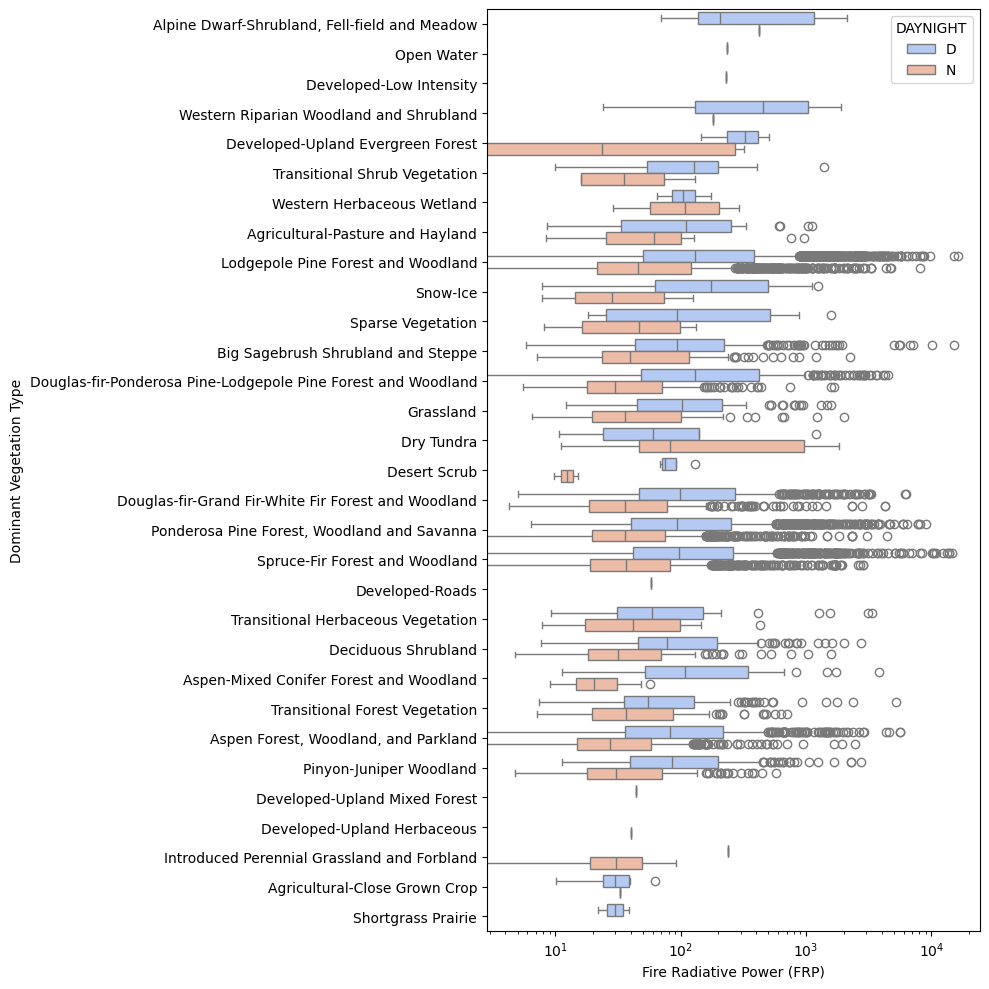

In [64]:
# Plot FRP by EVT group name
df = frp_evt_srm[frp_evt_srm['INSTRUMENT'] == 'MODIS']
# Get the 10 most common classes
top10 = evt_counts
# Find the median and sort the evt classes
med_frp = df.groupby('EVT_GP_N')['FRP'].median().sort_values(ascending=False)
sorted = med_frp.index.tolist()

plt.figure(figsize=(10, 10)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='EVT_GP_N', 
    hue='DAYNIGHT',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Vegetation Type')

plt.tight_layout()
plt.show()

### Calculate the percent aspen cover

In [54]:
# Identify aspen classes
aspen_classes = afds_evt_[afds_evt_['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(f"Aspen EVT classes in the Southern Rockies:\n{aspen_classes}\n")

Aspen EVT classes in the Southern Rockies:
['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'
 'Northwestern Great Plains Aspen Forest and Parkland']



## Sentinel-based Aspen Cover

In [ ]:
fp = os.path.join(maindir,'aspen-fire/Aim1/data/spatial/mod/results/classification/s2aspen_distribution_10m_y2019_CookEtAl.tif')
s2aspen_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = s2aspen_da.shape, s2aspen_da.spatial_ref.GeoTransform, s2aspen_da.rio.crs, s2aspen_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {s2aspen_da[0].dtype}")
gc.collect()

In [ ]:
t0 = time.time()

# Get the proportional landcover
afds_s2aspen = compute_band_stats(
    geoms=afds_, 
    image_da=s2aspen_da, 
    id_col='afdID',
    attr='s2aspen'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

In [ ]:
afds_s2aspen = afds_s2aspen[afds_s2aspen['s2aspen'] == 1]
afds_s2aspen.head()

In [ ]:
# Merge back to FRP

In [ ]:
# Make some plots. Just for the SRM.

In [ ]:
# Join back to FRP
frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']

evt = afds_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]

frp_evt_srm = pd.merge(frp, evt, on='afdID', how='left')
frp_evt_srm.head()

In [ ]:
# Create a "pct_forest" class
forest_classes = ['Hardwood', 'Conifer', 'Conifer-Hardwood']
frp_plots_forest = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(forest_classes)]
# Pivot table and calculate the percent forest
forest_cover = (
    frp_evt_srm[['afdID', 'EVT_PHYS', 'pct_cover']]
    .pivot_table(index='afdID', columns='EVT_PHYS', values='pct_cover', aggfunc='sum', fill_value=0)
)
forest_cover['pct_forest'] = forest_cover[forest_classes].sum(axis=1)
# Merge back to the main data frame
frp_evt_srm = frp_evt_srm.merge(forest_cover[['pct_forest']], on='afdID')
frp_evt_srm['pct_forest'].describe()

In [ ]:
# Now filter to retain just the aspen composition in FRP observations
frp_evt_srm_aspen = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(aspen_classes)]
# What percent of FRP observations have an aspen component?
aspenpct = len(frp_evt_srm_aspen['afdID'].unique()) / len(frp_evt_srm['afdID'].unique()) * 100
print(f"In the Southern Rockies, {aspenpct:.2f} of MODIS/VIIRS AFD have an aspen component.")

In [ ]:
plt.figure(figsize=(6, 4))

frp_plots_aspen_d = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'D']
frp_plots_aspen_n = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'N']

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(frp_plots_aspen_d['FRP']), fill=True, label="Daytime Obs.")
sns.kdeplot(np.log1p(frp_plots_aspen_n['FRP']), fill=True, label="Nighttime Obs.")

# Set plot title and axis labels
plt.title('Log density of FRP for any aspen (Southern Rockies)')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_aspen-any_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(12, 4))

frp_plots_aspen_ = frp_evt_srm_aspen[frp_evt_srm_aspen['FRP'] > 0]

for aspen_class in aspen_classes:
    subset = frp_plots_aspen_[frp_plots_aspen_['EVT_NAME'] == aspen_class]
    sns.scatterplot(x='pct_cover', y='FRP', data=subset, label=aspen_class)

plt.yscale('log')

plt.title('FRP vs Percent Cover of Aspen Classes')
plt.xlabel('Percent Cover of Aspen')
plt.ylabel('Fire Radiative Power (FRP)')
plt.legend(title='Aspen Class')

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

del frp_plots_aspen_

In [ ]:
# Identify the dominant EVT types.

In [ ]:
# Identify the dominant EVT class for each observation
dominant_evt = afds_evt.loc[afds_evt.groupby('afdID')['pct_cover'].idxmax()]
dominant_evt.head()

In [ ]:
print(f"There are {len(dominant_evt['EVT_GP_N'].unique())} EVT_GP_N categories.\n")
print(dominant_evt['EVT_GP_N'].unique())

In [ ]:
# Save this file out as well.
out_fp = os.path.join(projdir,'data/tabular/mod/EVT/afd_aspen-fires_2018_to_2023_buffer-EVT-dominant.csv')
dominant_evt.to_csv(out_fp)
print(f"Saved zonal statistics to: {out_fp}")

In [ ]:
# Join back to FRP
frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']
evt = dominant_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]
frp_evt = pd.merge(frp, evt, on='afdID', how='left')
frp_evt.head()

In [60]:
# Plot FRP by EVT group name

df = frp_evt[frp_evt['INSTRUMENT'] == 'VIIRS']

med_frp = df.groupby('EVT_GP_N')['FRP'].median().sort_values(ascending=False)
sorted = med_frp.index.tolist()

plt.figure(figsize=(10, 10)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='EVT_GP_N', 
    hue='DAYNIGHT',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Vegetation Type')

plt.tight_layout()
plt.show()

NameError: name 'frp_evt' is not defined

### Calculate the CBD, CBH, and CC from LANDFIRE

Now we calculate zonal statistics for these continuous attributes from LANDFIRE (e.g., mean within the AFD buffer zone).

In [ ]:
start = time.time()    

# Read in the LANDFIRE layers
cbd_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBD_200_CONUS/Tif/LC20_CBD_200.tif')
cbh_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBH_200_CONUS/Tif/LC20_CBH_200.tif')
tcc_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CC_200_CONUS/Tif/LC20_CC_200.tif')

lf_paths = [cbd_path, cbh_path, tcc_path]
attrs = ['cbd','cbh','tcc']

results = []
for i in range(len(lf_paths)):
    lf = lf_paths[i]
    attr = attrs[i]
    print(f'Processing {os.path.basename(lf)}')

    # Open the raster data and crop to bounds as before
    lf_da = rxr.open_rasterio(lf, masked=True, cache=False).squeeze()
    lf_da_crop = lf_da.rio.clip_box(
        minx=bounds[0]+1000, # +1000 meters for a small buffer
        miny=bounds[1]+1000, 
        maxx=bounds[2]+1000, 
        maxy=bounds[3]+1000
    )

    if not lf_da_crop.rio.crs == afds.crs:
        print("CRS mismatch, fixing !")
        lf_da_crop = lf_da_crop.rio.reproject(afds.crs)

    del lf_da # clean up
    
    # Calculate the zonal statistics
    zsdf = compute_band_stats(
        geoms=afds, 
        image_da=lf_da_crop, 
        id_col='afdID',
        attr=attr,
        stats=['mean'],
        ztype='continuous'
    )
    
    results.append(zsdf)
    del zsdf

print(f"\nTotal elapsed time: {round((time.time() - start)/60)} minutes")

In [ ]:
from functools import reduce
afd_lf_ = reduce(lambda left, right: pd.merge(left, right, on='afdID', how='inner'), results)
afd_lf_.head()

In [ ]:
# Join to the percent cover data
